In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from time import time

SKIP_TUNING=True

# Dataset loading
dataset = pd.read_csv(r"./NKI_bin_event.csv", sep=',')

dataset = dataset.drop("Patient", axis=1)
dataset = dataset.drop("survival", axis=1)
dataset = dataset.drop("survival_quartiles", axis=1)
dataset = dataset.drop("survival_binary", axis=1)
dataset = dataset.drop("surv_binary_event", axis=1)
dataset = dataset.drop("eventdeath", axis=1)
dataset = dataset.drop("ID", axis=1)
dataset = dataset.drop("barcode", axis=1)
dataset = dataset.drop("timerecurrence", axis=1)
dataset = dataset.drop("Unnamed: 0", axis=1)

train_idx = np.random.rand(len(dataset)) < 0.8
train_set = dataset[train_idx]
test_set  = dataset[~train_idx]

train_y = train_set.loc[:, "surv_quartile_event"]
new_train_y=train_set.loc[:, "surv_quartile_event"]
train_x = train_set.drop("surv_quartile_event", axis=1)
train_y = np.reshape(train_y.to_numpy(), (-1, 1))


test_y = test_set.loc[:, "surv_quartile_event"]
new_test_y = test_set.loc[:, "surv_quartile_event"]
test_x = test_set.drop("surv_quartile_event", axis=1)
test_y = np.reshape(test_y.to_numpy(), (-1, 1))


In [2]:

if not SKIP_TUNING:
  # Base RF classifier
  random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)


  # Utility function to report best scores
  def report(results, n_top=3):
      for i in range(1, n_top + 1):
          candidates = np.flatnonzero(results['rank_test_score'] == i)
          for candidate in candidates:
              print("Model with rank: {0}".format(i))
              print("Mean validation score: {0:.3f} (std: {1:.3f})"
                    .format(results['mean_test_score'][candidate],
                            results['std_test_score'][candidate]))
              print("Parameters: {0}".format(results['params'][candidate]))
              print("")

  # RF hyperparam tuning
  param_dist = {'bootstrap': [True, False],
                'min_impurity_decrease': stats.uniform(1e-7, 0),
                'criterion': ['gini', 'entropy'],
                'min_samples_split': range(2, 20),
                'min_samples_leaf': range(1, 20)}

  # run randomized search
  n_iter_search = 100
  random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                     n_iter=n_iter_search, scoring='recall_micro')

  start = time()
  random_search.fit(train_x, train_y)
  print("RandomizedSearchCV took %.2f seconds for %d candidates"
        " parameter settings." % ((time() - start), n_iter_search))
  report(random_search.cv_results_)

# Run RF with new parameters
random_forest = RandomForestClassifier(n_jobs=-1, bootstrap=False, criterion='entropy', min_impurity_split=1e-07, min_samples_leaf=5, min_samples_split=16)
random_forest.fit(train_x, train_y)
Y_pred_rf = random_forest.predict(test_x)
Y_pred_rf = np.reshape(Y_pred_rf, (-1, 1))

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


In [3]:
fi = pd.DataFrame({'feature': list(train_x.columns),
                   'importance': random_forest.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(20)

,feature,importance
1100,NM_016359,0.011242
708,NM_003981,0.007534
1093,AL049265,0.007341
864,NM_004986,0.006897
387,NM_004203,0.006766
456,NM_012319,0.006320
340,NM_003430,0.006036
827,NM_007019,0.005561
482,Contig56434_RC,0.005397
1011,NM_016109,0.005134


In [55]:
test_y.shape

(47, 1)

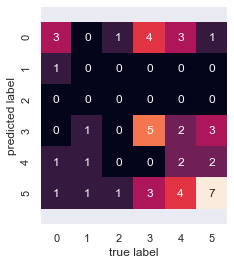

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(test_y, Y_pred_rf)
ax=sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [4]:
predictions = random_forest.predict(test_x)
# Performance metrics
errors = abs(predictions - test_y)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 2.71 degrees.
Accuracy: 35.8 %.
